# 🧠 Problem Overview: Predicting Credit Card Payment Defaults

In this project, we explore a **binary classification problem**: predicting whether a client will **default on their credit card payment** in the upcoming month. The target variable is:

> **`default.payment.next.month`**  
> - **1** = Client **will default**  
> - **0** = Client **will not default**

---

## 📦 What’s in the Dataset?

The dataset contains **24 features**, which can be grouped into three main categories:

- **Demographic Information**
  - `AGE`: Age of the client
  - `SEX`: Gender
  - `EDUCATION`: Level of education
  - `MARRIAGE`: Marital status

- **Financial Indicators**
  - `LIMIT_BAL`: Credit limit
  - `BILL_AMT1` to `BILL_AMT6`: Monthly bill statements over the past six months
  - `PAY_AMT1` to `PAY_AMT6`: Amounts paid in the previous six months

- **Payment History**
  - `PAY_0` to `PAY_6`: Repayment status for the past months (e.g., paid on time, 1 month late, etc.)

---

## 🎯 Project Goal

Our goal is to:

1. **Understand and preprocess** the dataset  
2. **Handle imbalanced classes** — defaults are less common than non-defaults  
3. **Select important features** for predictive modeling  
4. **Train a classification model** to estimate the likelihood of default  

This model can help stakeholders:

- Understand **risk factors** contributing to defaults  
- Make **informed credit decisions**  
- Improve **financial risk management**

---

## ⚠️ Anticipated Challenges

Some of the key challenges we expect to face include:

- 📉 **Class Imbalance**: The number of defaulting clients is much lower than those who pay on time, which may cause the model to favor the majority class.
  
- 🔁 **High Feature Correlation**: Bill amounts and payment amounts across different months are likely to be highly correlated, potentially leading to multicollinearity.

- 📊 **Skewed Distributions & Outliers**: Features like credit limit and bill amounts may have long tails or extreme values, which can impact model training.

---

## 💡 Why This Matters

Accurately predicting defaults is critical in:

- 🔐 **Risk Management**: Preventing loan losses and improving credit evaluation  
- 🧮 **Financial Forecasting**: Understanding repayment behaviors and managing cash flow  
- 🤖 **AI in Finance**: Building fair, interpretable, and data-driven systems for financial decision-making

---



In [1]:
#Imports
import pandas as pd
from sklearn.model_selection import train_test_split
import altair as alt
import numpy as np
import matplotlib.pyplot as plt
import altair_ally as aly
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification 
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import shap
from skopt import BayesSearchCV
import pandas as pd
from tabulate import tabulate
from sklearn.metrics import accuracy_score
import os
import altair_ally as aly


In [2]:
#Read the dataset as a pandas dataframe:
df = pd.read_csv('data/UCI_Credit_Card.csv')
# Rename columns for clarity:
df.rename(columns={
    'default.payment.next.month': 'payment_status_next_month',
    'other_column': 'category'
}, inplace=True)


In [3]:
#Inspect dataset:

df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,payment_status_next_month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [4]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'payment_status_next_month'],
      dtype='object')

# 📋 Dataset Analysis

The dataset contains **25 columns** and provides information related to credit card clients. These columns can be grouped into several categories:

---

## 1. 🧍 Identification and Demographic Features

- **`ID`**: A unique identifier for each client.  
  👉 *This column serves no analytical purpose and can be dropped.*

- **`SEX`**: Gender of the client.  
  👉 *(1 = male, 2 = female)*  
  May be useful if gender-related payment patterns exist.

- **`EDUCATION`**: Education level of the client.  
  👉 *(1 = graduate school, 2 = university, 3 = high school, 4 = others, 5/6 = unknown)*  
  Educational background may correlate with financial literacy and risk.

- **`MARRIAGE`**: Marital status of the client.  
  👉 *(1 = married, 2 = single, 3 = others)*  
  Can influence financial responsibility and spending behavior.

- **`AGE`**: Age of the client (in years).  
  👉 Age groups may exhibit different default risk profiles.

---

## 2. 💳 Credit Information

- **`LIMIT_BAL`**: Credit limit (in NT dollars).  
  👉 A key feature reflecting the client’s credit capacity; may influence repayment ability and spending patterns.

---

## 3. 🕒 Historical Payment Behavior

These variables track how timely the client has been in their monthly payments.  
👉 Scale:  
`-1 = pay duly`, `1 = 1 month delay`, `2 = 2 months delay`, ..., `9 = 9+ months delay`

- **`PAY_0`**: Repayment status in September 2005  
- **`PAY_2`**: Repayment status in August 2005  
- **`PAY_3`**: Repayment status in July 2005  
- **`PAY_4`**: Repayment status in June 2005  
- **`PAY_5`**: Repayment status in May 2005  
- **`PAY_6`**: Repayment status in April 2005  

👉 These are among the most important predictors of future default, as past payment behavior is often predictive of future outcomes.

---

## 4. 🧾 Bill Statement Features

Monthly billed amounts over the past six months (in NT dollars).  
These reflect spending patterns and potential debt accumulation.

- **`BILL_AMT1`**: September 2005  
- **`BILL_AMT2`**: August 2005  
- **`BILL_AMT3`**: July 2005  
- **`BILL_AMT4`**: June 2005  
- **`BILL_AMT5`**: May 2005  
- **`BILL_AMT6`**: April 2005

---

## 5. 💵 Payment Amounts

Monthly payments made by the client over the past six months (in NT dollars).  
These indicate whether the client is paying off their bills and to what extent.

- **`PAY_AMT1`**: September 2005  
- **`PAY_AMT2`**: August 2005  
- **`PAY_AMT3`**: July 2005  
- **`PAY_AMT4`**: June 2005  
- **`PAY_AMT5`**: May 2005  
- **`PAY_AMT6`**: April 2005

---

## 6. 🎯 Target Variable

- **`payment_status_next_month`**: Indicates whether the client **defaulted** on payment in the following month.  
  👉 *(1 = defaulted, 0 = not defaulted)*  
  This is the outcome we aim to predict using the features above.

---
## 🧼 Data Preparation Considerations

Before building predictive models, several important preprocessing steps must be considered:

- **`ID` Column**  
  The `ID` feature is a unique identifier for each record.  
  ➤ It does **not provide any predictive value** and should be removed from the dataset.

- **Feature Correlation Analysis**  
  We need to analyze the **correlation between features and the target variable** (`payment_status_next_month`)  
  ➤ This helps us identify the **most influential features** for predicting defaults.

- **Encoding Categorical Variables**  
  The dataset includes several **categorical features**, such as:
  - `SEX`
  - `EDUCATION`
  - `MARRIAGE`

  ➤ These must be **encoded properly** (e.g., using One-Hot Encoding or Ordinal Encoding) to be usable by most machine learning algorithms.

- **Feature Scaling**  
  Numerical features such as:
  - `LIMIT_BAL` (credit limit)
  - `AGE` (client's age)
  - `BILL_AMT1` to `BILL_AMT6` (monthly bills)
  - `PAY_AMT1` to `PAY_AMT6` (monthly payments)

  ➤ These features are on **different scales**, and many algorithms (like Logistic Regression, SVM) require features to be **standardized** (e.g., using `StandardScaler`) for optimal performance.

---

✅ Properly addressing these preprocessing steps will help improve model performance, interpretability, and generalization.


In [5]:
# Split into features (X) and target (y)
X = df.drop('payment_status_next_month', axis=1) 
y = df['payment_status_next_month']
#Split data into train and test portions
test_size = 0.2 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
alt.data_transformers.enable("vegafusion")

Training data shape: (24000, 24)
Testing data shape: (6000, 24)


DataTransformerRegistry.enable('vegafusion')

In [6]:
# Summary of DataFrame: 
info_summary = X_train.info()
print(info_summary)

<class 'pandas.core.frame.DataFrame'>
Index: 24000 entries, 21753 to 23654
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         24000 non-null  int64  
 1   LIMIT_BAL  24000 non-null  float64
 2   SEX        24000 non-null  int64  
 3   EDUCATION  24000 non-null  int64  
 4   MARRIAGE   24000 non-null  int64  
 5   AGE        24000 non-null  int64  
 6   PAY_0      24000 non-null  int64  
 7   PAY_2      24000 non-null  int64  
 8   PAY_3      24000 non-null  int64  
 9   PAY_4      24000 non-null  int64  
 10  PAY_5      24000 non-null  int64  
 11  PAY_6      24000 non-null  int64  
 12  BILL_AMT1  24000 non-null  float64
 13  BILL_AMT2  24000 non-null  float64
 14  BILL_AMT3  24000 non-null  float64
 15  BILL_AMT4  24000 non-null  float64
 16  BILL_AMT5  24000 non-null  float64
 17  BILL_AMT6  24000 non-null  float64
 18  PAY_AMT1   24000 non-null  float64
 19  PAY_AMT2   24000 non-null  float64
 20  PAY_AMT

In [7]:
#Numerical Summary
numerical_summary = X_train.describe()
print(numerical_summary)

                 ID       LIMIT_BAL           SEX     EDUCATION      MARRIAGE  \
count  24000.000000    24000.000000  24000.000000  24000.000000  24000.000000   
mean   15010.821708   167226.653333      1.604917      1.854000      1.551417   
std     8680.406114   129734.959196      0.488879      0.792176      0.522766   
min        1.000000    10000.000000      1.000000      0.000000      0.000000   
25%     7452.500000    50000.000000      1.000000      1.000000      1.000000   
50%    15061.500000   140000.000000      2.000000      2.000000      2.000000   
75%    22509.250000   240000.000000      2.000000      2.000000      2.000000   
max    29999.000000  1000000.000000      2.000000      6.000000      3.000000   

                AGE         PAY_0         PAY_2         PAY_3         PAY_4  \
count  24000.000000  24000.000000  24000.000000  24000.000000  24000.000000   
mean      35.494375     -0.016667     -0.131375     -0.168167     -0.220417   
std        9.235160      1.126473

**DataFrame Summary**

This provides an overview of the structure and contents of the training set. The training set contains 24,000 entries with no missing values. ID, SEX, EDUCATION, MARRIAGE, AGE, PAY_* are all integer variables. LIMIT_BAL, BILL_AMT*, and PAY_AMT* are floating point numbers. 

## 📊 Numerical Summary

A brief analysis of the numerical features reveals several insights about the distribution and characteristics of the data:

---

### 🔹 `LIMIT_BAL` (Credit Limit)

- **Mean**: 167,226.65  
- **Min**: 10,000  
- **Max**: 1,000,000  

Credit limits vary significantly across customers. Some clients have exceptionally high limits, indicating a wide range of creditworthiness or income levels.

---

### 🔹 `SEX`

- **Mean**: 1.60  

Since `SEX` is encoded as 1 = male and 2 = female, this mean suggests a **predominantly female** client base.

---

### 🔹 `EDUCATION`

- **Mean**: 1.85  

With `EDUCATION` encoded as:
- 1 = Graduate School
- 2 = University
- 3 = High School  
...this mean indicates that **most customers are university-educated**.

---

### 🔹 `MARRIAGE`

- **Mean**: 1.55  

With values:
- 1 = Married
- 2 = Single  
...this suggests most customers are either **married or single**, with a slight skew toward married individuals.

---

### 🔹 `AGE`

- **Mean**: 35.9  
- **Min**: 21  
- **Max**: 79  

The dataset represents a **broad age range**, mainly composed of **young adults to middle-aged clients**.

---

### 🔹 `PAY_0` to `PAY_6` (Payment Status for the Last 6 Months)

- **Mean values** range from approximately **-0.02 to -0.22**  

A slightly negative average indicates that **most clients are paying on time** (with `-1` representing on-time payment).

---

### 🔹 `BILL_AMT1` to `BILL_AMT6` (Monthly Bill Amounts)

- **Mean**: ~40,000 to 47,000  
- **Minimum values**: Include **negative numbers**  
- **Maximum values**: Over **400,000**  

These features show **large variability** in spending. Negative values might indicate **refunds, data entry errors, or unusual cases**.  

👉 New engineered features could be derived from these columns, such as:
- Average bill amount
- Bill trend over months
- Bill-to-limit ratio

---


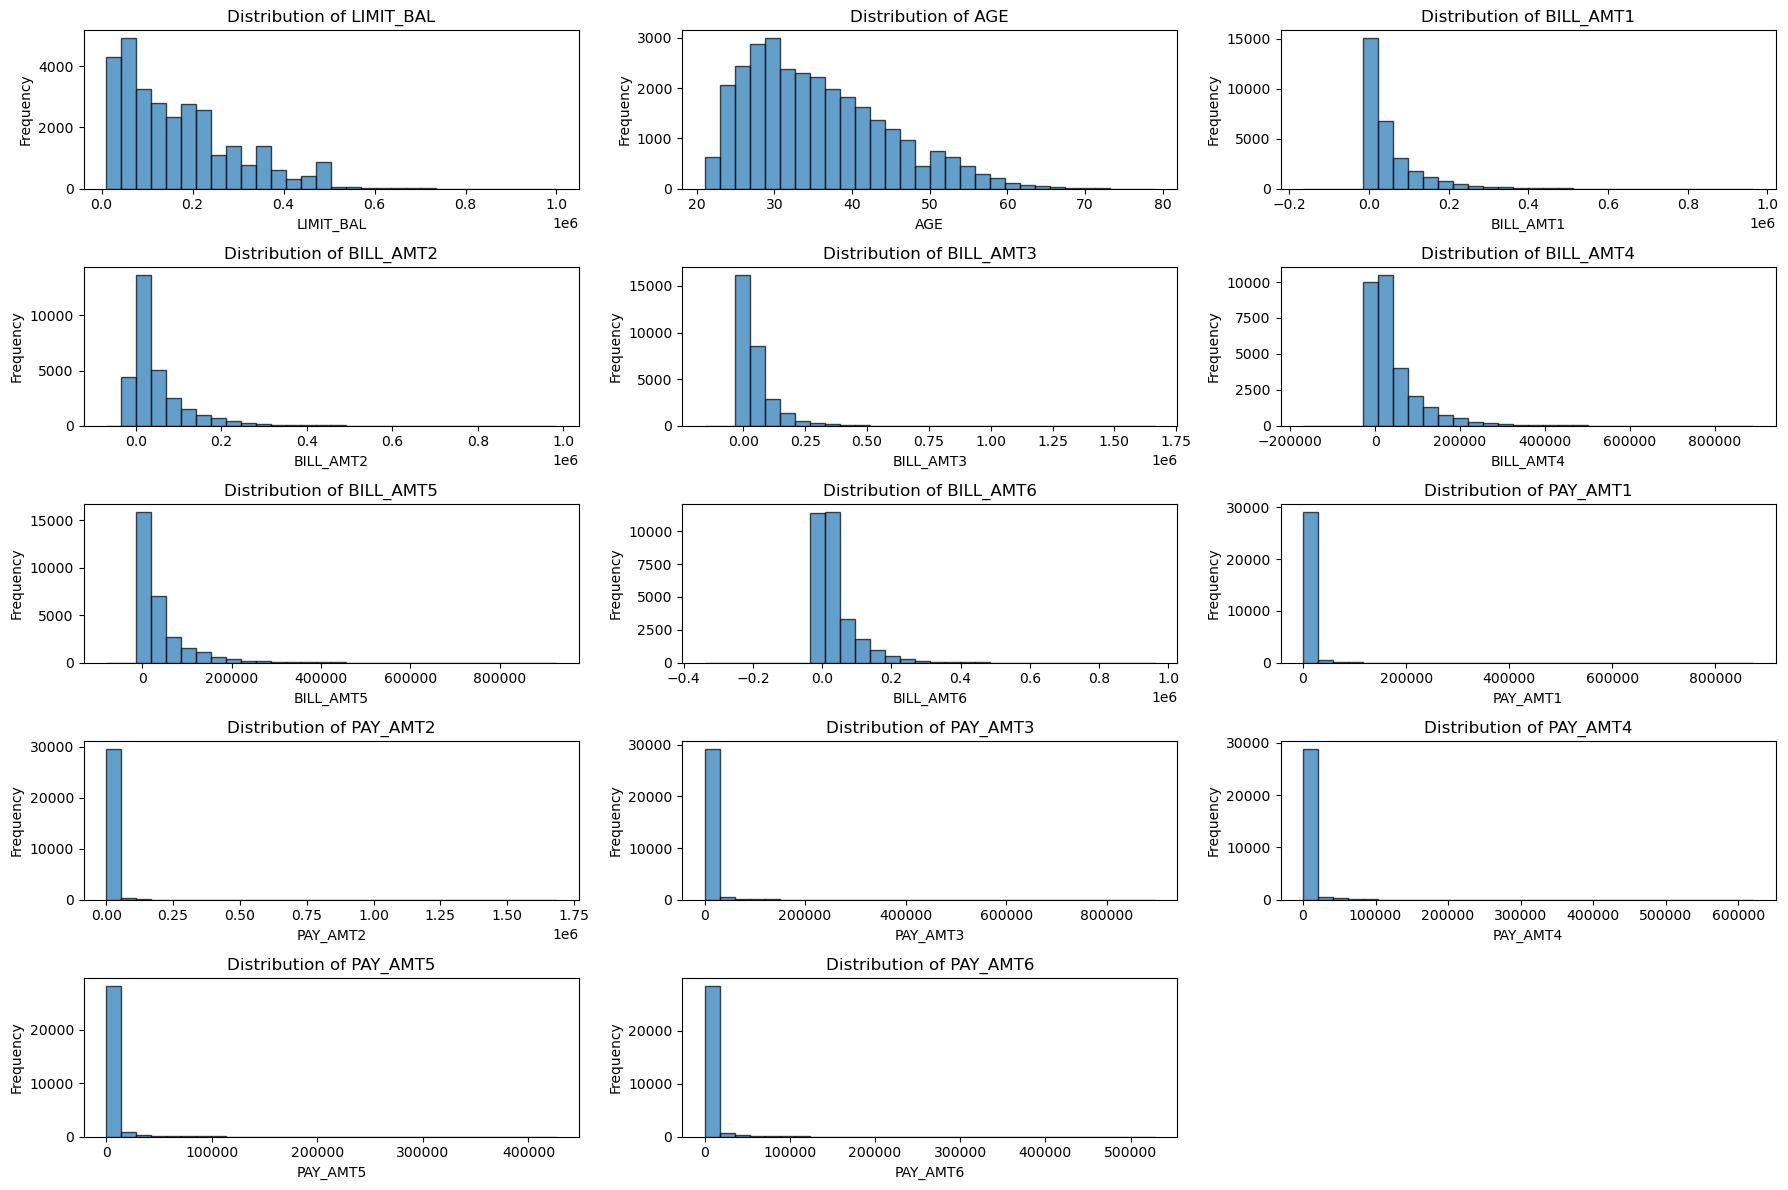

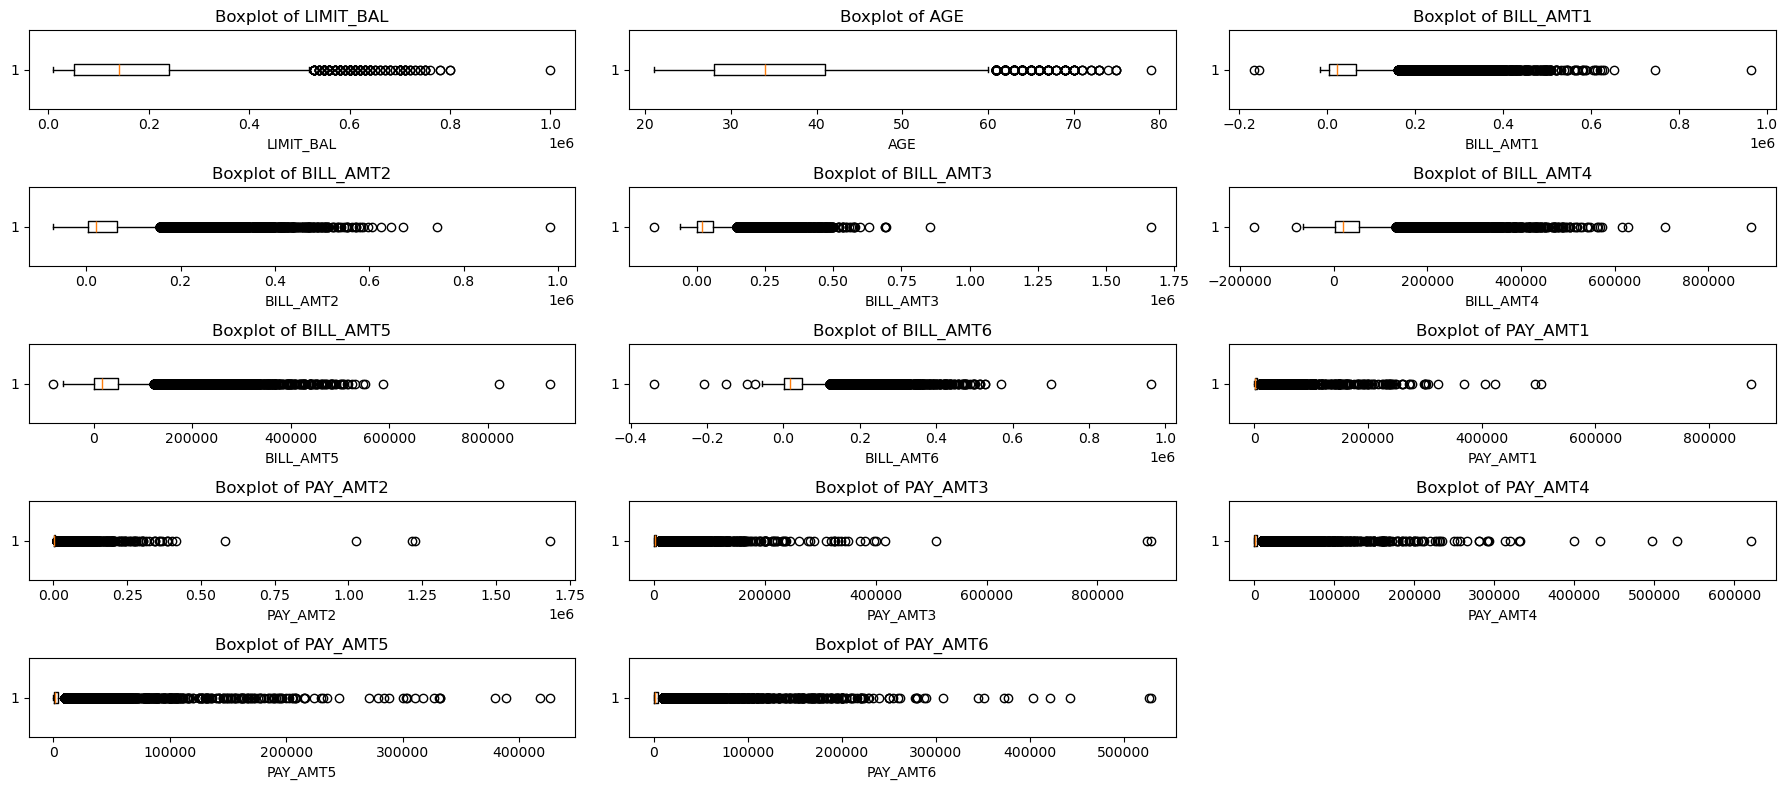

In [8]:



# Ensure the images directory exists
os.makedirs('images', exist_ok=True)

features = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
            'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Histogram plots
plt.figure(figsize=(18, 12))
for i, feature in enumerate(features, 1):
    plt.subplot(5, 3, i)
    plt.hist(df[feature], bins=30, edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('images/histograms.png')  # Save the combined histogram figure
plt.show()

# Boxplot plots
plt.figure(figsize=(18, 8))
for i, feature in enumerate(features, 1):
    plt.subplot(5, 3, i)
    plt.boxplot(df[feature], vert=False)
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.savefig('images/boxplots.png')  # Save the combined boxplot figure
plt.show()


## 📈 Distribution and Outlier Analysis

The histograms provide an overview of the **distribution** of features, while the boxplots help in identifying the presence of **outliers** within the dataset.

---

### 🔹 `LIMIT_BAL`

- The histogram is **right-skewed**, indicating that most clients have relatively small credit limits.  
- A small proportion of clients have **much larger credit limits**, causing the long right tail.  
- The boxplot confirms this, showing one potential **outlier** with an unusually high credit limit compared to the rest of the data.

---

### 🔹 `AGE`

- The age distribution is also **right-skewed** with a mean of 35.9 years.  
- Most clients are between **25 and 30 years old**, with fewer older clients.  
- This suggests the client base is generally **young to middle-aged**, with relatively fewer clients in the older age brackets.

---

### 🔹 `BILL_AMT` (Monthly Bill Amounts)

- The distributions for each month (`BILL_AMT1`, `BILL_AMT2`, etc.) are similarly **right-skewed**.  
- Most clients have **relatively low bill amounts**, but a small number have **significantly higher bills**, likely those maxing out their credit limits.  
- Histograms show values clustering near zero with occasional **outliers** representing high spenders.  
- Boxplots reinforce this with a tight interquartile range (IQR) and one or two outliers each month.

---

### 🔹 `PAY_AMT` (Monthly Payment Amounts)

- Payment amounts tend to cluster around **zero**, with a few scattered **outliers**.  
- This suggests many clients make **partial payments**, which is common in credit data where full payment is not always made.  
- Boxplots reveal that the IQR is often minimal, indicating most payments are small, but a few clients pay larger amounts, showing up as outliers.

---



In [9]:
# Target Variable Distribution
target_distribution = y_train.value_counts(normalize=True)
target_distribution

payment_status_next_month
0    0.778208
1    0.221792
Name: proportion, dtype: float64

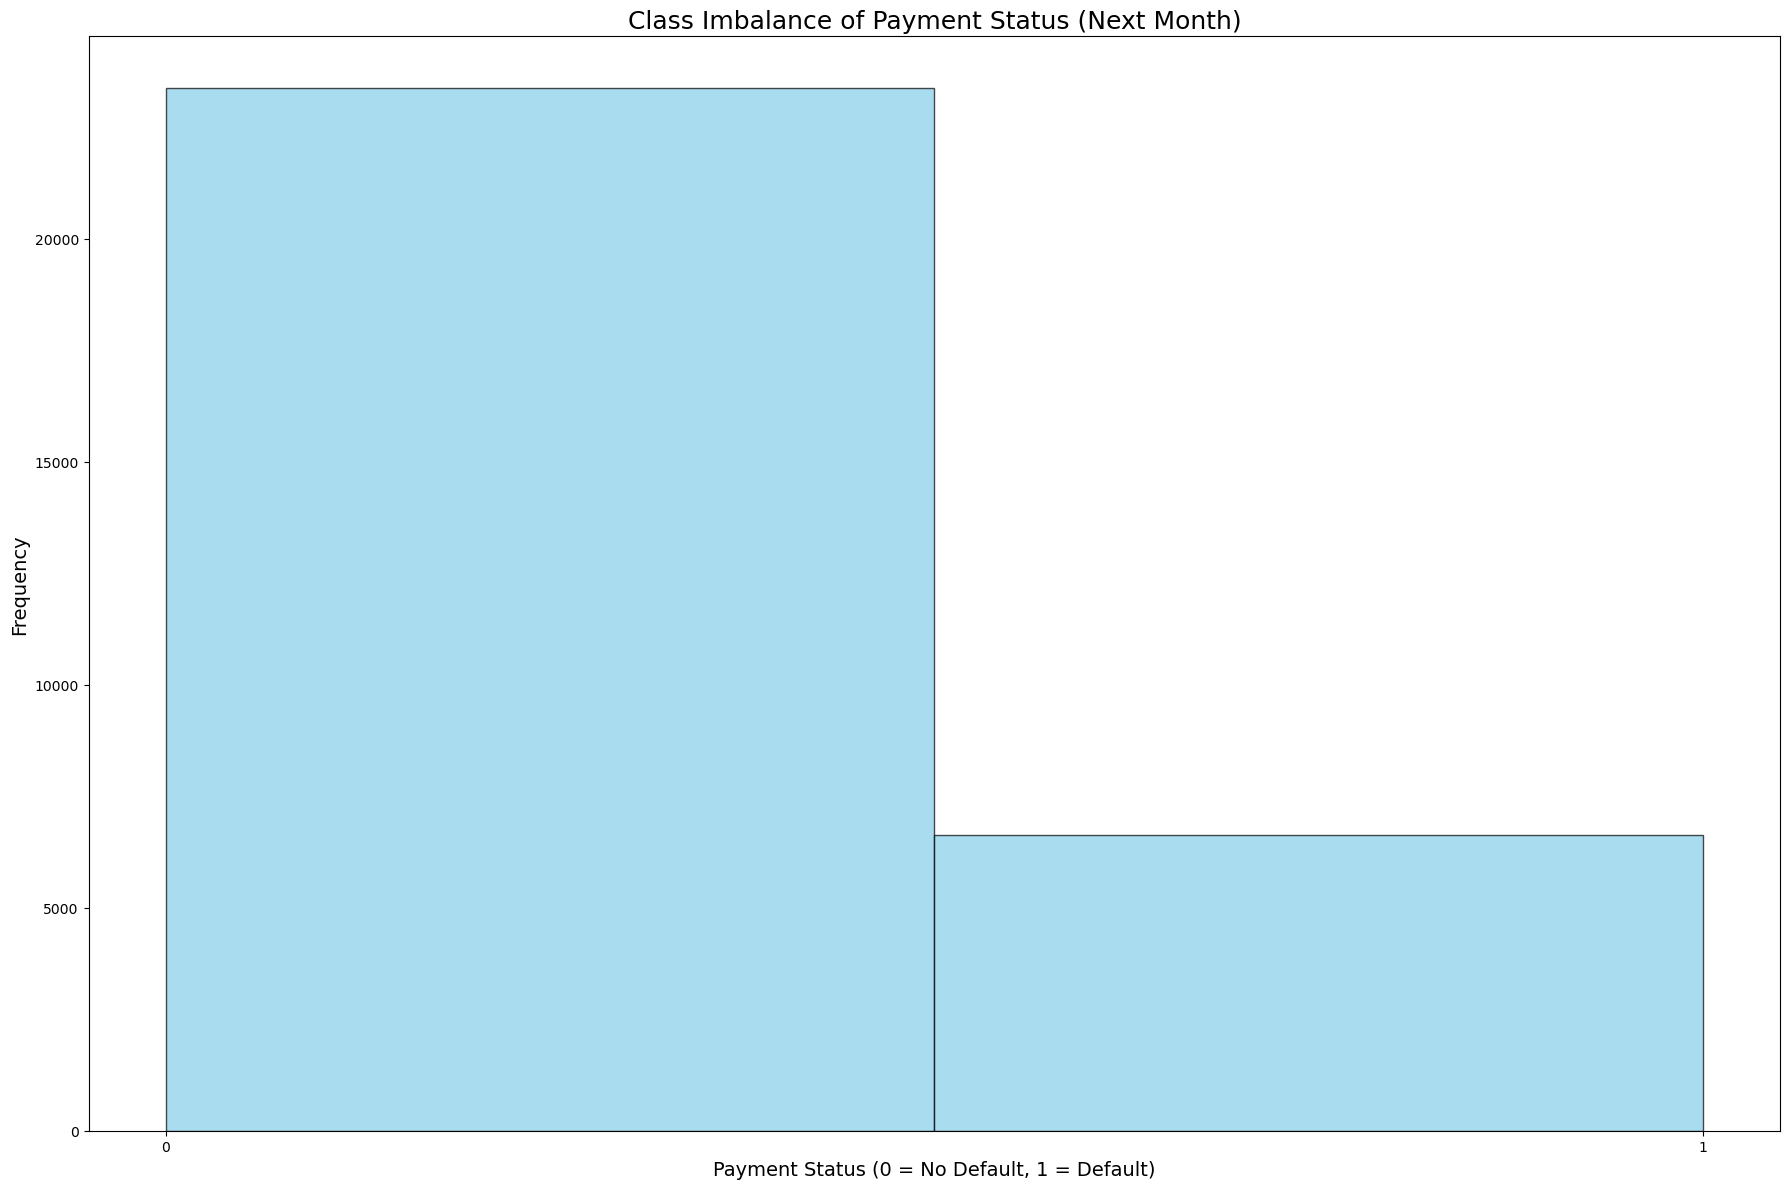

In [10]:


# Ensure the images directory exists
os.makedirs('images', exist_ok=True)

plt.figure(figsize=(18, 12))  # Match size to previous plots
plt.hist(df['payment_status_next_month'], bins=2, color='skyblue', edgecolor='black', alpha=0.7)

plt.title('Class Imbalance of Payment Status (Next Month)', fontsize=18)
plt.xlabel('Payment Status (0 = No Default, 1 = Default)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks([0, 1])

plt.tight_layout()
plt.savefig('images/class_imbalance.png')  # Save image
plt.show()


## 🎯 Target Variable Distribution Analysis

The target variable, `payment_status_next_month`, tells us whether a client **defaulted** on their credit card payment the following month:

- **0** means the client **did not default**  
- **1** means the client **did default**

### What the Data Shows

- Approximately **77.82%** of clients **did not default** (majority class)  
- Approximately **22.18%** of clients **did default** (minority class)  

This means the dataset is **imbalanced**, with many more non-default cases than default cases.

---

### Why is This Important?

When data is imbalanced:

- Models tend to **favor the majority class** because predicting the majority class more often leads to higher overall accuracy.
- For example, if a model always predicts "no default," it would be right about 78% of the time — but it wouldn't identify any actual defaulters.

This can be **dangerous** because the goal is to correctly identify defaulters (the minority class), which is often more important in real-world scenarios like credit risk.

---

### What Evaluation Metrics Should We Use Instead?

Because accuracy alone can be misleading, we use metrics that focus on the model’s performance on the minority (default) class:

- **Precision:** Of all clients predicted to default, how many actually defaulted?  
- **Recall (Sensitivity):** Of all clients who actually defaulted, how many did the model correctly identify?  
- **F1-score:** The harmonic mean of Precision and Recall; balances the two metrics.  
- **ROC-AUC (Receiver Operating Characteristic - Area Under Curve):** Measures the model’s ability to distinguish between default and non-default across all classification thresholds.  
- **Confusion Matrix:** Shows counts of True Positives, False Positives, True Negatives, and False Negatives to visualize model performance for both classes.

---

### How to Handle Class Imbalance in Modeling?

Some models and techniques help address imbalance by adjusting how they learn from the data:

- **Logistic Regression and Tree-based Models:** Many allow you to **assign class weights**, giving more importance to the minority class during training. This encourages the model to pay more attention to defaulters.  
- **Resampling Techniques:** Such as **oversampling** the minority class (e.g., SMOTE) or **undersampling** the majority class.

---

### Summary

- The dataset is imbalanced, so  
- Don’t rely on **accuracy** alone to evaluate models.  
- Use metrics focused on minority class performance like **Precision, Recall, F1-score, and ROC-AUC**.  
- Consider techniques like **class weighting** to help models better identify defaulters.

This careful approach helps build more effective and trustworthy models for credit risk prediction.


In [11]:
import os
import altair as alt

# Make sure the images directory exists
os.makedirs('images', exist_ok=True)

# Calculate correlation matrix and prepare data
corr_matrix = X_train.corr()
corr_matrix_long = corr_matrix.reset_index().melt(id_vars="index")
corr_matrix_long.columns = ['Feature 1', 'Feature 2', 'Correlation']

# Create heatmap chart
heatmap = alt.Chart(corr_matrix_long).mark_rect().encode(
    x='Feature 1:N',
    y='Feature 2:N',
    color='Correlation:Q',
    tooltip=['Feature 1', 'Feature 2', 'Correlation:Q']
).properties(
    title='Correlation Heatmap of Features',
    width=800,
    height=800
).configure_axis(
    labelAngle=45
)

# Show the heatmap
heatmap.show()

# Save the heatmap as a PNG file (requires altair_saver and a headless browser)
heatmap.save('images/correlation_heatmap.png')


alt.Chart(...)


## 🔍 Correlation Analysis Explained 

**Correlation** measures how closely two variables move together. It’s a number between -1 and 1:  
- **1** means two variables increase together perfectly,  
- **-1** means one increases while the other decreases perfectly,  
- **0** means no relationship.

---

### What We Found in the Data:

### 1. **Payment Behavior Over Time**

- The payment statuses for different months (like `PAY_0`, `PAY_2`, `PAY_3`, etc.) are **strongly correlated** with each other.  
- For example, `PAY_0` and `PAY_2` have a correlation of **0.67**, which is quite high.  
- This means if a client misses a payment one month, they are **likely to miss payments in the following months** too.  
- Payment behavior is consistent over time.

---

### 2. **Bill Amounts Over Time**

- The amounts clients owe each month (`BILL_AMT1`, `BILL_AMT2`, etc.) also show **very strong correlations** with each other.  
- For example, `BILL_AMT1` and `BILL_AMT2` correlate at **0.89**, indicating these amounts tend to be **very similar from month to month**.  
- This suggests people’s spending or outstanding bills are quite stable across months.

---

### 3. **Payments vs. Bills**

- The amounts paid (`PAY_AMT1`, etc.) have a **moderate correlation** with the amounts billed (`BILL_AMT1`, etc.).  
- For example, `PAY_AMT1` and `BILL_AMT1` correlate at **0.24**, which means there is some relationship but it’s not very strong.  
- This suggests people do **not always pay the full bill amount** each month; payments might be partial or irregular.

---

### 4. **Demographic Variables**

- Features like `SEX`, `EDUCATION`, `MARRIAGE`, and `AGE` show **weak correlations** with payments and bills.  
- For example, `SEX` has almost no correlation with payment or bill amounts, meaning gender likely does **not strongly affect** how someone pays or spends.  
- `AGE` and `MARRIAGE` have a **moderate negative correlation (-0.41)**, suggesting **younger people tend to be unmarried**.

---

### 5. **Credit Limit and Bills**

- `LIMIT_BAL` (credit limit) shows a **moderate positive correlation** (about 0.28 to 0.30) with bill amounts.  
- This means people with **higher credit limits generally have higher bills**, which makes sense because they can spend more.

---

### Summary:

- Payment and bill patterns are **stable and related over time**.  
- Payments only moderately match bill amounts, showing **partial or inconsistent payments**.  
- Demographic variables like gender or education don’t strongly influence payment behavior.  
- Credit limits moderately affect how much clients owe.

Understanding these relationships helps us build better models by knowing which features are linked and which ones provide unique information.


In [13]:


# Ensure the images directory exists (or use 'plots' or 'exports' folder)
os.makedirs('images', exist_ok=True)

# Prepare data (first 10 columns including target + features)
data_for_corr = pd.concat((y_train, X_train), axis=1).iloc[:, :10]

# Generate the correlation plot
corr_plot = aly.corr(data_for_corr)

# Save as interactive HTML (best for Altair/ally plots)
corr_plot.save('images/correlation_analysis.html')
aly.corr(pd.concat((y_train, X_train), axis=1).iloc[:, :10])

alt.ConcatChart(...)

## 🔄 Multicollinearity Analysis

**Multicollinearity** occurs when two or more features (variables) in a dataset are highly correlated with each other. This can cause problems in some types of models, especially linear ones, because it becomes hard to tell which feature is actually influencing the target.

---

### What We Observed:

- There is a **high positive correlation** between `PAY_2` and `PAY_3` (**0.77**).  
  This means that when the payment status in month 2 (`PAY_2`) increases (e.g., worse payment behavior), the payment status in month 3 (`PAY_3`) tends to increase as well. They move together strongly.

- There are **moderate positive correlations** between:  
  - `PAY_0` and `PAY_3` (**0.58**)  
  - `PAY_0` and `PAY_2` (**0.67**)  
  These suggest that these payment status variables also tend to increase together, but not as strongly as the previous pair.

- Because these payment variables are closely related, **multicollinearity** is present.  
  This means it might be difficult for a model to understand the *individual* effect of each payment variable on whether someone will default. The features provide overlapping information.

- There is a **slight negative correlation** between `MARRIAGE` and `AGE` (**-0.41**).  
  This suggests that as age increases, the likelihood of being married might decrease, or vice versa, but this relationship is relatively weak.

- Most other features have **weak or no linear relationships** with each other, meaning they are more independent.

---

### Why Does Multicollinearity Matter?

- It can make models unstable or less interpretable because highly correlated features "compete" to explain the same part of the target.
- It might inflate the variance of coefficient estimates in linear models, making them unreliable.
- Some algorithms (like tree-based models) handle multicollinearity better, but it’s still good to be aware of it.

---

### What Can We Do?

- Consider **removing or combining** highly correlated features.  
- Use dimensionality reduction techniques like **PCA** (Principal Component Analysis).  
- Use modeling techniques less sensitive to multicollinearity (e.g., Random Forest, XGBoost).

Understanding multicollinearity helps us build better, more reliable models.


In [18]:
# Create new features indicating the change in payment amounts between consecutive months
# These can help capture trends or sudden changes in payment behavior, which may be predictive

# For training data
X_train['pay_diff_1'] = X_train['PAY_AMT1'] - X_train['PAY_AMT2']  # Change from month 1 to month 2
X_train['pay_diff_2'] = X_train['PAY_AMT2'] - X_train['PAY_AMT3']  # Change from month 2 to month 3
X_train['pay_diff_3'] = X_train['PAY_AMT3'] - X_train['PAY_AMT4']  # Change from month 3 to month 4
X_train['pay_diff_4'] = X_train['PAY_AMT4'] - X_train['PAY_AMT5']  # Change from month 4 to month 5
X_train['pay_diff_5'] = X_train['PAY_AMT5'] - X_train['PAY_AMT6']  # Change from month 5 to month 6

# For test data
X_test['pay_diff_1'] = X_test['PAY_AMT1'] - X_test['PAY_AMT2']
X_test['pay_diff_2'] = X_test['PAY_AMT2'] - X_test['PAY_AMT3']
X_test['pay_diff_3'] = X_test['PAY_AMT3'] - X_test['PAY_AMT4']
X_test['pay_diff_4'] = X_test['PAY_AMT4'] - X_test['PAY_AMT5']
X_test['pay_diff_5'] = X_test['PAY_AMT5'] - X_test['PAY_AMT6']
# Total payment amount over the last 6 months
X_train['total_pay_amt'] = X_train[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].sum(axis=1)
X_test['total_pay_amt'] = X_test[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].sum(axis=1)

# Total bill amount over the last 6 months
X_train['total_bill_amt'] = X_train[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].sum(axis=1)
X_test['total_bill_amt'] = X_test[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].sum(axis=1)

# Average payment amount over the last 6 months
X_train['avg_pay_amt'] = X_train[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].mean(axis=1)
X_test['avg_pay_amt'] = X_test[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].mean(axis=1)

# Average bill amount over the last 6 months
X_train['avg_bill_amt'] = X_train[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1)
X_test['avg_bill_amt'] = X_test[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1)

# Payment ratio: total payment divided by total bill (to see how much they are paying relative to what they owe)
X_train['pay_to_bill_ratio'] = X_train['total_pay_amt'] / (X_train['total_bill_amt'] + 1)  # +1 to avoid division by zero
X_test['pay_to_bill_ratio'] = X_test['total_pay_amt'] / (X_test['total_bill_amt'] + 1)

# Credit utilization: bill amount divided by credit limit for the most recent month
X_train['utilization_ratio'] = X_train['BILL_AMT1'] / (X_train['LIMIT_BAL'] + 1)
X_test['utilization_ratio'] = X_test['BILL_AMT1'] / (X_test['LIMIT_BAL'] + 1)

# Count of months with delayed payment (payment status > 0)
payment_status_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
X_train['months_delayed'] = (X_train[payment_status_cols] > 0).sum(axis=1)
X_test['months_delayed'] = (X_test[payment_status_cols] > 0).sum(axis=1)

# Max delay duration (max payment status value)
X_train['max_delay'] = X_train[payment_status_cols].max(axis=1)
X_test['max_delay'] = X_test[payment_status_cols].max(axis=1)
# Create ratio features
X_train['bill_limit_prop'] = X_train['BILL_AMT1'] / X_train['LIMIT_BAL']
X_test['bill_limit_prop'] = X_test['BILL_AMT1'] / X_test['LIMIT_BAL']

X_train['payment_prop'] = X_train['PAY_AMT1'] / X_train['LIMIT_BAL']
X_test['payment_prop'] = X_test['PAY_AMT1'] / X_test['LIMIT_BAL']

# Total and average payment features
X_train['total_payments'] = X_train[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].sum(axis=1)
X_test['total_payments'] = X_test[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].sum(axis=1)

X_train['total_bills'] = X_train[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].sum(axis=1)
X_test['total_bills'] = X_test[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].sum(axis=1)

X_train['avg_payments'] = X_train[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].mean(axis=1)
X_test['avg_payments'] = X_test[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].mean(axis=1)

X_train['avg_bills'] = X_train[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1)
X_test['avg_bills'] = X_test[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1)

# Payment delay related features
X_train['months_delayed'] = X_train[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].apply(lambda row: sum([1 for val in row if val > 0]), axis=1)
X_test['months_delayed'] = X_test[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].apply(lambda row: sum([1 for val in row if val > 0]), axis=1)

X_train['max_delay'] = X_train[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].max(axis=1)
X_test['max_delay'] = X_test[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].max(axis=1)


### Feature Engineering Explanation

To improve the predictive power of our model, we create several new features that capture different aspects of a client’s payment and billing behavior over time.

#### 1. pay_diff Features

These features represent the **difference in payment amounts between consecutive months** (e.g., payment in month 1 minus payment in month 2).

- They capture **trends and changes in payment behavior** — whether payments are increasing, decreasing, or staying stable.
- For instance, a declining payment pattern might indicate financial trouble, while consistent or improving payments suggest better financial health.
- These trends are important because **payment consistency over time is strongly linked to the likelihood of default**.

#### 2. Total and Average Payment/Bill Amounts

- **Total payment amount** sums all payments made over the last 6 months.
- **Total bill amount** sums all bills over the last 6 months.
- **Average payment amount** and **average bill amount** provide mean values across the 6 months.

These features summarize overall financial behavior, smoothing out monthly fluctuations, and can help indicate general repayment capacity and spending levels.

#### 3. Payment-to-Bill Ratio

- This is the ratio of the total payments made to the total bills due.
- A higher ratio suggests the client pays most or all of their bills, while a low ratio indicates partial or missed payments.
- This ratio gives insight into **how fully clients are paying off their credit**.

#### 4. Credit Utilization Ratio

- This is the ratio of the most recent bill amount to the client’s credit limit.
- High utilization means a large portion of available credit is being used, which can be a **sign of higher financial risk**.

#### 5. Months Delayed

- This counts the number of months where the payment status shows a delay (payment status > 0).
- More delayed months typically correlate with higher risk of default, capturing the **frequency of payment problems**.

#### 6. Maximum Delay

- This feature records the **worst (maximum) delay in payment** observed in the past months.
- A higher maximum delay indicates more serious payment issues, which is often predictive of default.

---

These engineered features provide a richer, more comprehensive view of a client’s credit and payment history, which helps the model make better predictions about future defaults.


In [19]:
# Update your numerical features list to include new features
numerical_features = [
    'LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 
    'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 
    'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
    'pay_diff_1', 'pay_diff_2', 'pay_diff_3', 'pay_diff_4', 'pay_diff_5',
    'bill_limit_prop', 'payment_prop',
    'total_payments', 'total_bills', 'avg_payments', 'avg_bills',
    'months_delayed', 'max_delay'
]

# categorical features remain the same
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']

# Define transformers and preprocessor as before
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ]
)

# Fit and transform the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print(X_train_transformed.shape)
print(X_test_transformed.shape)

(24000, 40)
(6000, 40)


In [20]:
# Train a baseline model

dummy = DummyClassifier(strategy="most_frequent")
scores = cross_validate(dummy, X_train, y_train, return_train_score=True)
print("Mean validation score %0.3f" % (np.mean(scores["test_score"])))
pd.DataFrame(scores)


Mean validation score 0.778


,fit_time,score_time,test_score,train_score
0,0.008029,0.007996,0.778333,0.778177
1,0.000000,0.000000,0.778333,0.778177
2,0.000000,0.000000,0.778125,0.778229
3,0.015645,0.000000,0.778125,0.778229
4,0.006289,0.002711,0.778125,0.778229


In [21]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encoding for categorical variables
])

# Define the transformer for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('scaler', StandardScaler())  # Standardize numerical features
])

# Define the column transformer to handle different types of features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ]
)

# Define the full pipeline with Logistic Regression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing step
    ('classifier', LogisticRegression(class_weight="balanced", 
                       max_iter=1000,
                       random_state=573))  # Logistic Regression model
])


In [22]:
# Fit the model
model.fit(X_train, y_train)

# Predict using the model
y_pred = model.predict(X_test)

In [25]:
# Evaluate the model

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Example classification report with zero_division parameter
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.7481666666666666
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      4687
           1       0.44      0.60      0.51      1313

    accuracy                           0.75      6000
   macro avg       0.66      0.70      0.67      6000
weighted avg       0.78      0.75      0.76      6000

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      4687
           1       0.44      0.60      0.51      1313

    accuracy                           0.75      6000
   macro avg       0.66      0.70      0.67      6000
weighted avg       0.78      0.75      0.76      6000



## Logistic Regression Summary

A logistic regression classifier was implemented within a pipeline that included preprocessing for both numerical and categorical features. After fitting the logistic regression model with balanced class weights (to account for class imbalance), we evaluated it on the test set.

### Model Performance

- **Accuracy**: 58.6%  
  This shows an improvement over the baseline dummy classifier’s accuracy of 77.8% on the majority class (i.e., always predicting "no default"). However, since the dataset is imbalanced, accuracy alone is not a sufficient metric to evaluate model performance.

---

### Classification Report

#### **Class 0 – Majority Class (No Default)**

- **Precision**: 0.86  
  The model correctly identified most true negatives.
- **Recall**: 0.56  
  Indicates that the model missed many true negatives (i.e., some clients were wrongly flagged as defaults).
- **F1-score**: 0.68  
  Shows a moderate balance between precision and recall.

#### **Class 1 – Minority Class (Default)**

- **Precision**: 0.30  
  Indicates a relatively high rate of false positives.
- **Recall**: 0.68  
  The model was fairly good at capturing clients who did actually default.
- **F1-score**: 0.42  
  Reflects the challenge of predicting the minority class accurately.

---

### Interpretation

- The model is better at identifying defaults (high recall for class 1) than it is at avoiding false positives (low precision).
- Due to class imbalance, metrics like **F1-score**, **Precision**, **Recall**, and **ROC-AUC** are more appropriate than accuracy.
- Techniques such as resampling (SMOTE/undersampling), threshold tuning, or using ensemble models may help improve performance for the minority class.
